In [18]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [19]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [22]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [23]:
print(df['label'].unique())


['Anthropogenic' 'Non Informative' 'Fire' 'flood' 'Cyclone'
 'River Erosion' 'Earthquake']


In [24]:
import pandas as pd

# Define the mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())

[5 4 0 1 3 2]


In [25]:
print(df['label'].value_counts())

label
5    697
0    510
1    509
4    505
2    500
3    445
Name: count, dtype: int64


In [26]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [27]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Prepare data for TextDataset
X_train = train_data['caption'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values


In [28]:
import random

# Random Deletion
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

# Random Swap
def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Character-level Noise
def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

# Combine all augmentations
def augment_bengali_text(text):
    # Step 1: Random Deletion
    text = random_deletion_bn(text, p=0.1)
    # Step 2: Random Swap
    text = random_swap_bn(text, n=1)
    # Step 3: Character-level noise
    text = char_noise_bn(text, p=0.03)
    return text

# Apply augmentation to your dataset
df['caption_aug'] = df['caption'].apply(augment_bengali_text)

print(df[['caption', 'caption_aug']].head(10))  # Check a sample


                                                caption  \
1057  পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...   
5405          বিকট শব্দে সিলিন্ডারবোঝাই ট্রাকে বিস্ফোরণ   
5628  গোপালগঞ্জে একটি ভবনে আগুন, দমকল বাহিনী দ্রুত ব...   
1406  মাদাগাস্কারের রেইনফরেস্টে বন উজাড়ের কারণে লেমু...   
2857  বন্যায় ভীষণভাবে ক্ষতিগ্রস্ত হয়েছে স্পেনের ভ্যা...   
1195  বাংলাদেশে গ্রামাঞ্চলে টিকা গ্রহণের হার কম, সংক...   
511   অনেকের বাড়ি আর ফিরে পাওয়া যাবে না… পথ এখন অনিশ...   
5077          দুশ্চিন্তায় কেটে যায় অনেক সময়, নদীতে ভাঙন   
3055  ঘূর্ণিঝড় ইয়াসে লন্ডভন্ড সেন্ট মার্টিনের পর্যট...   
3172        প্রবল ঘূর্ণিঝড় থেকে স্থল নিম্নচাপ 'বুলবুল'   

                                            caption_aug  
1057  পাইলটের শেষ মুএূর্তের প্রচেষ্টা বিমান দুর্ঘটনা...  
5405                 শব্দে বিকট সিলিন্ডারবোঝাই বিস্ফোরণ  
5628  গোপালগঞ্জে এঔটি দমকল ভবনে বাহিনী দ্রুত ব্যবস্থ...  
1406  মাদাগাসগকারের রেইনফরেস্টে উজাড়ের কামণে লেমুর প...  
2857  বন্যায় ভীষণবাবে স্পেনপর হয়েছে ক্ষতিয্রসবত ধ্যা...  
11

In [29]:
from transformers import XLMRobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Use XLM-Roberta's tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_ds = TextDataset(X_train, y_train, tokenizer)
valid_ds = TextDataset(X_valid, y_valid, tokenizer)
test_ds = TextDataset(X_test, y_test, tokenizer)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)


In [30]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
from torch.nn.functional import cross_entropy, one_hot

class SmoothedCELoss(torch.nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        n_classes = logits.size(1)
        true_dist = torch.zeros_like(logits)
        true_dist.fill_(self.smoothing / (n_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * logits.log_softmax(dim=1), dim=1))


In [31]:
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import tqdm

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use XLM-Roberta for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',  # or 'xlm-roberta-large' for better performance
    num_labels=6
).to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.2)
total_steps = len(train_dl) * 20
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.1 * total_steps),
    num_training_steps=total_steps
)

patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(20):
    if early_stop:
        print("Early stopping triggered")
        break

    model.train()
    total_loss = 0
    correct, total = 0, 0
    for batch in tqdm(train_dl, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = smoothed_ce_loss(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_dl)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in valid_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dl)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_xlmr.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            early_stop = True


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 119/119 [00:28<00:00,  4.21it/s]


Epoch 1, Training Loss: 1.7835, Training Accuracy: 19.75%
Validation Loss: 1.7040, Validation Accuracy: 41.86%


Epoch 2: 100%|██████████| 119/119 [00:28<00:00,  4.15it/s]


Epoch 2, Training Loss: 1.6233, Training Accuracy: 37.97%
Validation Loss: 1.3279, Validation Accuracy: 63.51%


Epoch 3: 100%|██████████| 119/119 [00:28<00:00,  4.12it/s]


Epoch 3, Training Loss: 1.1907, Training Accuracy: 67.72%
Validation Loss: 0.7935, Validation Accuracy: 80.09%


Epoch 4: 100%|██████████| 119/119 [00:28<00:00,  4.11it/s]


Epoch 4, Training Loss: 0.8569, Training Accuracy: 78.52%
Validation Loss: 0.5854, Validation Accuracy: 85.62%


Epoch 5: 100%|██████████| 119/119 [00:28<00:00,  4.11it/s]


Epoch 5, Training Loss: 0.6773, Training Accuracy: 83.15%
Validation Loss: 0.4559, Validation Accuracy: 87.36%


Epoch 6: 100%|██████████| 119/119 [00:29<00:00,  4.08it/s]


Epoch 6, Training Loss: 0.5506, Training Accuracy: 86.31%
Validation Loss: 0.4082, Validation Accuracy: 87.99%


Epoch 7: 100%|██████████| 119/119 [00:29<00:00,  4.07it/s]


Epoch 7, Training Loss: 0.4689, Training Accuracy: 88.78%
Validation Loss: 0.3756, Validation Accuracy: 88.47%


Epoch 8: 100%|██████████| 119/119 [00:29<00:00,  4.05it/s]


Epoch 8, Training Loss: 0.4088, Training Accuracy: 90.63%
Validation Loss: 0.3403, Validation Accuracy: 89.57%


Epoch 9: 100%|██████████| 119/119 [00:29<00:00,  4.05it/s]


Epoch 9, Training Loss: 0.3580, Training Accuracy: 91.68%
Validation Loss: 0.3227, Validation Accuracy: 90.05%


Epoch 10: 100%|██████████| 119/119 [00:29<00:00,  4.06it/s]


Epoch 10, Training Loss: 0.3198, Training Accuracy: 92.68%
Validation Loss: 0.3191, Validation Accuracy: 90.05%


Epoch 11: 100%|██████████| 119/119 [00:29<00:00,  4.04it/s]


Epoch 11, Training Loss: 0.3022, Training Accuracy: 92.94%
Validation Loss: 0.3127, Validation Accuracy: 90.21%


Epoch 12: 100%|██████████| 119/119 [00:29<00:00,  4.04it/s]


Epoch 12, Training Loss: 0.2819, Training Accuracy: 93.21%
Validation Loss: 0.3109, Validation Accuracy: 90.36%


Epoch 13: 100%|██████████| 119/119 [00:29<00:00,  4.04it/s]


Epoch 13, Training Loss: 0.2569, Training Accuracy: 94.15%
Validation Loss: 0.3068, Validation Accuracy: 90.05%


Epoch 14: 100%|██████████| 119/119 [00:29<00:00,  4.04it/s]


Epoch 14, Training Loss: 0.2380, Training Accuracy: 94.94%
Validation Loss: 0.2935, Validation Accuracy: 90.52%


Epoch 15: 100%|██████████| 119/119 [00:29<00:00,  4.03it/s]


Epoch 15, Training Loss: 0.2259, Training Accuracy: 94.94%
Validation Loss: 0.2943, Validation Accuracy: 90.52%


Epoch 16: 100%|██████████| 119/119 [00:29<00:00,  4.04it/s]


Epoch 16, Training Loss: 0.2071, Training Accuracy: 95.73%
Validation Loss: 0.2925, Validation Accuracy: 91.15%


Epoch 17: 100%|██████████| 119/119 [00:29<00:00,  4.03it/s]


Epoch 17, Training Loss: 0.2147, Training Accuracy: 95.42%
Validation Loss: 0.2949, Validation Accuracy: 90.52%


Epoch 18: 100%|██████████| 119/119 [00:29<00:00,  4.02it/s]


Epoch 18, Training Loss: 0.2027, Training Accuracy: 95.37%
Validation Loss: 0.2903, Validation Accuracy: 90.84%


Epoch 19: 100%|██████████| 119/119 [00:29<00:00,  4.02it/s]


Epoch 19, Training Loss: 0.1996, Training Accuracy: 95.47%
Validation Loss: 0.2927, Validation Accuracy: 90.68%


Epoch 20: 100%|██████████| 119/119 [00:29<00:00,  4.02it/s]


Epoch 20, Training Loss: 0.1984, Training Accuracy: 96.16%
Validation Loss: 0.2906, Validation Accuracy: 90.84%
No improvement in validation loss for 2 epochs. Stopping training.


Text(0.5, 1.0, 'Loss Curves')

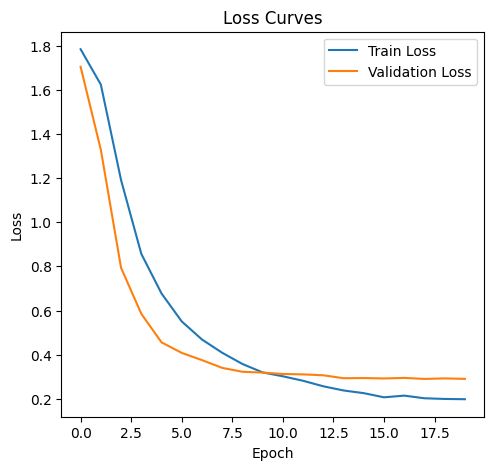

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.title('Accuracy Curves')

# plt.savefig('training_curves.png')  # Save the figure as a file

# plt.show()


In [33]:
import pandas as pd

# Create a DataFrame for easy visualization
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses)+1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy (%)': train_accuracies,
    'Validation Accuracy (%)': val_accuracies
})

print(df)

# Optionally, save to a CSV file for later analysis
df.to_csv('training_metrics.csv', index=False)


    Epoch  Train Loss  Validation Loss  Train Accuracy (%)  \
0       1    1.783502         1.703997           19.747235   
1       2    1.623253         1.327857           37.967351   
2       3    1.190738         0.793506           67.719853   
3       4    0.856877         0.585397           78.515008   
4       5    0.677327         0.455907           83.149026   
5       6    0.550632         0.408214           86.308583   
6       7    0.468892         0.375590           88.783570   
7       8    0.408820         0.340331           90.626646   
8       9    0.358014         0.322729           91.679831   
9      10    0.319785         0.319080           92.680358   
10     11    0.302208         0.312698           92.943655   
11     12    0.281946         0.310896           93.206951   
12     13    0.256922         0.306822           94.154818   
13     14    0.238020         0.293496           94.944708   
14     15    0.225893         0.294261           94.944708   
15     1

Test Accuracy: 92.59%

Classification Report:
              precision    recall  f1-score   support

           0     0.9259    0.8772    0.9009       114
           1     0.8901    0.8710    0.8804        93
           2     0.9080    0.9405    0.9240        84
           3     0.9167    0.8713    0.8934       101
           4     0.9487    0.9911    0.9694       112
           5     0.9481    0.9846    0.9660       130

    accuracy                         0.9259       634
   macro avg     0.9229    0.9226    0.9224       634
weighted avg     0.9254    0.9259    0.9252       634



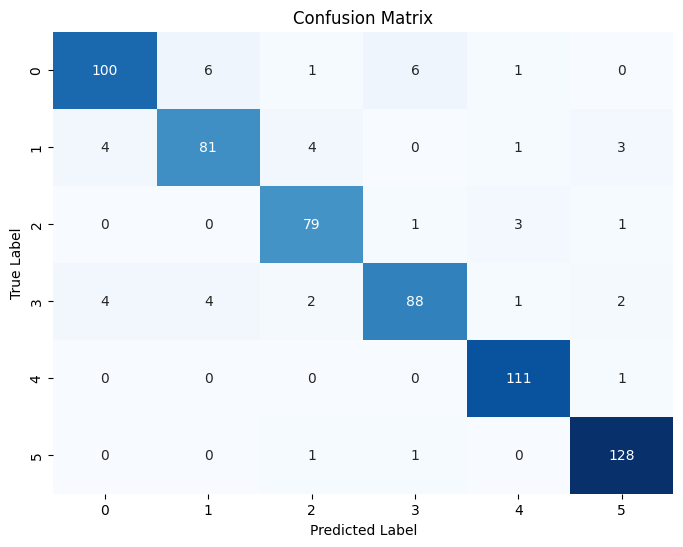

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = 100 * (sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels))
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
